1a. W_enc -> Dxd. W_dec -> dxD

1b. We can set the encoders weights to be the first r columns of V. The decoders weights can be set to the first r columns of U and the first r singular values

In [1]:
%matplotlib inline
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
import requests
from io import BytesIO
import tqdm

bucky_urls = [
    "https://cdn.vox-cdn.com/thumbor/3yCbVJHk2QeCNc47W6yaR2ok-OE=/0x0:4298x2925/920x613/filters:focal(1806x1120:2492x1806):format(webp)/cdn.vox-cdn.com/uploads/chorus_image/image/66531240/usa_today_11199458.0.jpg",
    "https://www.ncaa.com/_flysystem/public-s3/styles/large_16x9/public-s3/images/2020-07/uw-badgers.jpg?h=13158095&itok=SA0HJYHQ",
    "https://chancellor.wisc.edu/content/uploads/2018/08/Bucky_Parade_unveil18_7137.jpg",
]
def get_image_from_url(url):
    response = requests.get(url,headers={'User-Agent': 'Mozilla/5.0'})
    img = Image.open(BytesIO(response.content))
    img = img.resize((128,128))
    return img

def prepare_image_for_torch(img):
    img_arr = np.asarray(img) / 255.
    img_arr = torch.from_numpy(img_arr).float()
    return img_arr

In [2]:
class AutoEncoder(nn.Module):
    def __init__(self, in_chans, hidden_chans=10):
        super().__init__()
        self.encoder = nn.Linear(in_chans, hidden_chans, bias=False)
        self.decoder = nn.Linear(hidden_chans, in_chans, bias=False)

        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.001)

    def forward(self, x):
        B,H,W,D = x.shape
        x = x.flatten(1)
        z = self.encoder(x)
        xpred = self.decoder(z)
        return xpred.view(B,H,W,D)

In [3]:
def loss(pred, y):
    """MSE loss"""
    return (pred - y).pow(2).mean()

def fit(model, loss, images, iterations=300):
    """
    Helper function to train a model.
    - images: NxWxHx3 tensor
    - iterations: number of training iterations
    """
    opt = torch.optim.Adam(model.parameters(), lr=0.0005)
    for it in tqdm.tqdm(range(iterations)):
        pred = model(images)
        l = loss(pred, images)

        l.backward()
        opt.step()
        opt.zero_grad()
    return model

@torch.no_grad()
def display_reconstructions(model):
    """
    Helper function to visualize reconstructions obtained through the autoencoder.
    """
    for i, url in enumerate(bucky_urls):
        img = get_image_from_url(url)
        img_arr = prepare_image_for_torch(img)
        img_rec = autoencoder(img_arr[None])[0]

        plt.subplot(len(bucky_urls),2,1+i*2)
        plt.imshow(img)
        plt.axis(False)
        plt.subplot(len(bucky_urls),2,2+i*2)
        plt.imshow(img_rec.numpy().clip(0, 1))
        plt.axis(False)

100%|██████████| 300/300 [00:06<00:00, 44.34it/s]


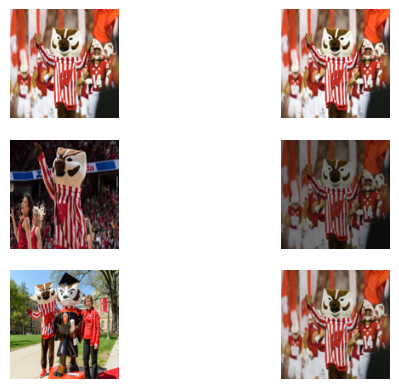

In [4]:
# Declare the model
autoencoder = AutoEncoder(128*128*3, 10)

# Prepare training data
img = get_image_from_url(bucky_urls[0])
img_arr = prepare_image_for_torch(img)[None]

# Fit the model
fit(autoencoder, loss, img_arr)

# Display results
display_reconstructions(autoencoder)

100%|██████████| 300/300 [00:03<00:00, 93.55it/s]


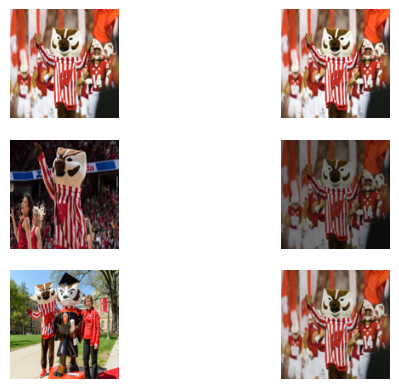

In [5]:
# Part b)
# Step 1: Prepare all 3 images and stack them into a 3xHxWxD tensor
imgs = [prepare_image_for_torch(get_image_from_url(url)) for url in bucky_urls]
imgs_tensor = torch.stack(imgs)

# Step 2: Declare model, fit to data, visualize results
autoencoder_all = AutoEncoder(128*128*3, 10)
fit(autoencoder_all, loss, imgs_tensor)
display_reconstructions(autoencoder_all)

#### (c)	Why is the model not generalizing well to new images? Suggest two ideas to improve the generalization of the model.
It could be overfitting to the training image(s). Because there's limited training data, it overcompensates the weights for the training data, making it bad for generalizing new data. We could train on a more diverse dataset, or perform data augmentation

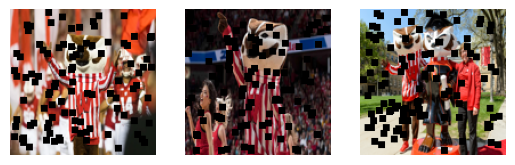

In [6]:
# Part d) and e)
# Step 1: Prepare all 3 images and stack them into a 3xHxWxD tensor
all_images = [prepare_image_for_torch(get_image_from_url(url)) for url in bucky_urls]
all_images_tensor = torch.stack(all_images)

# Step 2: Rewrite fit_with_noise() so that, at each iteration, images are first corrupted with noise. Then, passed to the autoencoder for denoising.
# Step 3: Declare the model, fit to data, visualize results

def add_noise(img):
    img = img.clone()
    rows = img.shape[0]
    cols = img.shape[1]
    s = int(min(rows,cols)/20) # size of spot is 1/20 of smallest dimension

    for i in range(100):
        x = np.random.randint(cols-s)
        y = np.random.randint(rows-s)
        img[y:(y+s),x:(x+s)] = 0

    return img

for i, url in enumerate(bucky_urls):
    img = get_image_from_url(url)
    img = prepare_image_for_torch(img)

    plt.subplot(1, 3, 1+i)
    plt.imshow(add_noise(img))
    plt.axis(False)

100%|██████████| 300/300 [00:03<00:00, 87.71it/s]


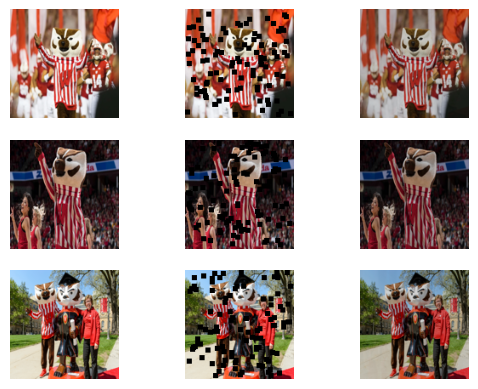

In [7]:
@torch.no_grad()
def display_reconstructions_with_noise(model):
    for i, url in enumerate(bucky_urls):
        img = get_image_from_url(url)
        img_arr = prepare_image_for_torch(img)
        img_noise = add_noise(img_arr)
        img_rec = model(img_noise[None])[0]

        plt.subplot(len(bucky_urls),3,1+i*3)
        plt.imshow(img)
        plt.axis(False)
        plt.subplot(len(bucky_urls),3,2+i*3)
        plt.imshow(img_noise.numpy().clip(0, 1))
        plt.axis(False)
        plt.subplot(len(bucky_urls),3,3+i*3)
        plt.imshow(img_rec.numpy().clip(0, 1))
        plt.axis(False)

def fit_with_noise(model, loss, images, iterations=300):
    opt = torch.optim.Adam(model.parameters(), lr=0.0005)
    for it in tqdm.tqdm(range(iterations)):
        noisy_images = add_noise(images)
        pred = model(noisy_images)
        l = loss(pred, images)  # Note: We're comparing the predicted denoised images to the original ones

        l.backward()
        opt.step()
        opt.zero_grad()
    return model

denoising_autoencoder = AutoEncoder(128*128*3, 10)
fit_with_noise(denoising_autoencoder, loss, all_images_tensor)

# Visualization
@torch.no_grad()
def display_denoised_reconstructions(model):
    for i, url in enumerate(bucky_urls):
        img = get_image_from_url(url)
        img_arr = prepare_image_for_torch(img)
        img_noise = add_noise(img_arr)
        img_rec = model(img_noise[None])[0]

        plt.subplot(len(bucky_urls),3,1+i*3)
        plt.imshow(img)
        plt.axis(False)
        plt.subplot(len(bucky_urls),3,2+i*3)
        plt.imshow(img_noise.numpy().clip(0, 1))
        plt.axis(False)
        plt.subplot(len(bucky_urls),3,3+i*3)
        plt.imshow(img_rec.numpy().clip(0, 1))
        plt.axis(False)

# Show the original, noisy, and denoised images side by side
display_denoised_reconstructions(denoising_autoencoder)